# 2ª Lista de Exercícios - Questão 2

Programa de Pós-Graduação em Informática (PPGI - UFPB)

Nome: Thiago Viana de Carvalho

Semestre: 2018.1

Para resolver problemas com Redes Neurais, assim como qualquer problema de aprendizado de máquina, antes de elaborar uma arquitetura é necessário primeiramente entender o problema e, principalmente, compreender os dados. Esse processo é extenso e compreende muitas vezes a maior parte do trabalho, de forma que podemos pensar em uma pirâmide, em que no topo está a arquitetura da rede de fato e, antes disso, estão os processos de obtenção e manipulação de dados, ilustrado na Figura 1. Dessa forma, esse notebook tem como objetivo introduzir alguns pontos importantes da pirâmide para obtenção de melhores resultados de uma rede neural. O notebook é organizado de acordo com seis pontos principais:

    - Definição do problema
    - Entendendo o dataset
    - Identificando problemas
    - Solucionando problemas
    - Correlação
    - Implementando a rede neural
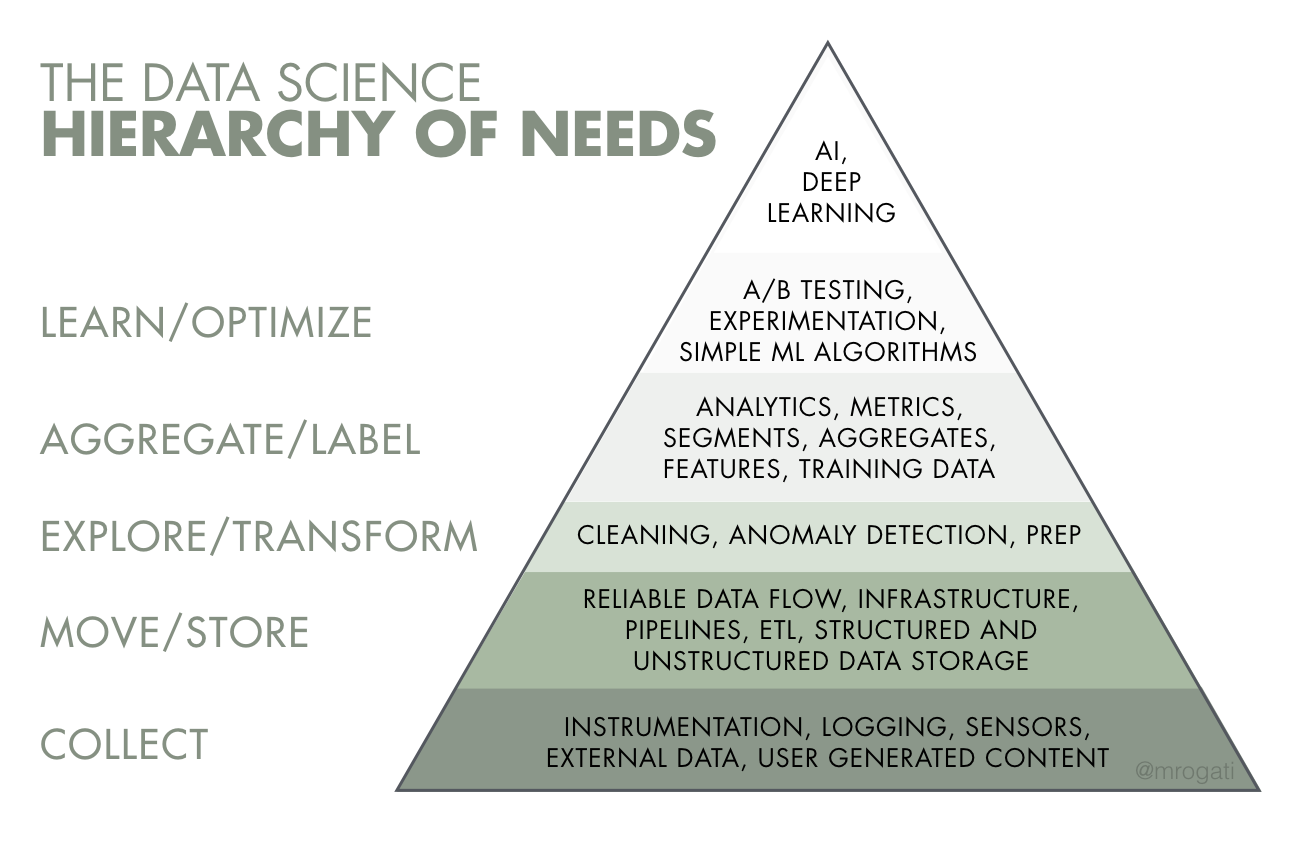

## Definição do problema
Nessa atividade, será utilizado como base de dados informações dos passageiros do Titanic para identificar quais passageiros sobreviveram. No Titanic, uma das razões que causou o naufrágio foi que não havia botes salva-vidas suficientes para os passageiros e a tripulação. Dentre os passageiros, alguns grupos de pessoas tinham maior probabilidade de sobreviver do que outros, como mulheres, crianças e a classe alta. Dessa forma, o problema consiste em utilizar rede neural para identificar quais pessoas poderiam sobreviver. A base de dados é dividida em treino e teste, considere a base de teste titanic3.xls. Para leitura do arquivo em Python, utilize a função do Pandas para leitura de arquivos. O treino deverá ser realizado por validaçaão cruzada e por holdout e os resultados devem ser comparados.

### Importações utilizadas

In [198]:
import keras
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import Dropout
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

### Análise do dataset

Para a análise dos dados de entrada do dataset, foi utilizado o Pandas, biblioteca de Python que permite analisar e preprocessar dados.

In [199]:
### Leitura do dataset
train_data = pd.read_excel('dataset/titanic3.xls', sheet_name="titanic3")
print(len(train_data))
train_data[:5]

1309


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


### Identificando problemas
Mesmo com uma base de dados previamente definida, muitas vezes existem problemas que não foram tratados nela, sendo necessário analisar manualmente. Dentre os problemas, para bases de texto, três são bastante comuns:

    - Instâncias com informações faltando (NaN) para determinados atributos
    - Dados discrepantes e outliers
    - Dados desbalanceados
    
Para o tratamento dos dados, primeiramente binarizamos a coluna referente ao gênero das pessoas. Em seguida, removemos os atributos considerados irrelevantes para o treinamento/classificação ('PassengerId', 'Name', 'Ticket' e 'Cabin'). Também transformamos a categoria 'Embarked' em subcategorias binárias (semelhante a classificação one hot)

In [200]:
### Tratamento dos dados
## Transformando a coluna 'Sex' em valores binários (m = 0, f = 1)
train_data['sex'] = train_data['sex'].map({"male": 0, "female": 1})

## Removendo atributos irrelevantes para o treinamento/classificação
train_data.drop(columns=['home.dest', 'boat', 'body', 'name', 'ticket', 'cabin'], inplace=True)

## Descartando os NaNs
train_data.dropna(axis=0, how='any', inplace=True)

## Transformando a coluna 'Embarked' em subcategorias
train_data = pd.get_dummies(train_data, dummy_na=False).astype(float)
print(len(train_data))
train_data[:8]

1043


,pclass,survived,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
0,1.0,1.0,1.0,29.0000,0.0,0.0,211.3375,0.0,0.0,1.0
1,1.0,1.0,0.0,0.9167,1.0,2.0,151.5500,0.0,0.0,1.0
2,1.0,0.0,1.0,2.0000,1.0,2.0,151.5500,0.0,0.0,1.0
3,1.0,0.0,0.0,30.0000,1.0,2.0,151.5500,0.0,0.0,1.0
4,1.0,0.0,1.0,25.0000,1.0,2.0,151.5500,0.0,0.0,1.0
5,1.0,1.0,0.0,48.0000,0.0,0.0,26.5500,0.0,0.0,1.0
6,1.0,1.0,1.0,63.0000,1.0,0.0,77.9583,0.0,0.0,1.0
7,1.0,0.0,0.0,39.0000,0.0,0.0,0.0000,0.0,0.0,1.0


In [201]:
## Identificação de possíveis outliers
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pclass,1043.0,2.209012,0.840685,1.0000,1.00,2.00,3.0000,3.0000
survived,1043.0,0.407478,0.491601,0.0000,0.00,0.00,1.0000,1.0000
sex,1043.0,0.370086,0.483059,0.0000,0.00,0.00,1.0000,1.0000
age,1043.0,29.813199,14.366261,0.1667,21.00,28.00,39.0000,80.0000
sibsp,1043.0,0.504314,0.913080,0.0000,0.00,0.00,1.0000,8.0000
parch,1043.0,0.421860,0.840655,0.0000,0.00,0.00,1.0000,6.0000
fare,1043.0,36.603024,55.753648,0.0000,8.05,15.75,35.0771,512.3292
embarked_C,1043.0,0.203260,0.402617,0.0000,0.00,0.00,0.0000,1.0000
embarked_Q,1043.0,0.047939,0.213739,0.0000,0.00,0.00,0.0000,1.0000
embarked_S,1043.0,0.748802,0.433910,0.0000,0.00,1.00,1.0000,1.0000


In [202]:
##Ignorar os dados discrepantes e outliers das colunas 'Fare' e 'Age'
train_data = train_data[np.abs(train_data['age'] - train_data['age'].mean()) <= (2.5*train_data['age'].std())]
train_data = train_data[np.abs(train_data['fare'] - train_data['fare'].mean()) <= (1.2*train_data['fare'].std())]
#print(len(train_data))
train_data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
pclass,955.0,2.314136,0.794213,1.0000,2.00,3.0,3.000,3.0
survived,955.0,0.383246,0.486432,0.0000,0.00,0.0,1.000,1.0
sex,955.0,0.350785,0.477466,0.0000,0.00,0.0,1.000,1.0
age,955.0,28.942670,13.633617,0.1667,21.00,27.0,37.000,65.0
sibsp,955.0,0.492147,0.924107,0.0000,0.00,0.0,1.000,8.0
parch,955.0,0.385340,0.814050,0.0000,0.00,0.0,0.000,6.0
fare,955.0,23.506535,21.057916,0.0000,8.05,13.9,28.625,93.5
embarked_C,955.0,0.170681,0.376427,0.0000,0.00,0.0,0.000,1.0
embarked_Q,955.0,0.051309,0.220743,0.0000,0.00,0.0,0.000,1.0
embarked_S,955.0,0.778010,0.415802,0.0000,1.00,1.0,1.000,1.0


##### Distribuição dos dados (Age)

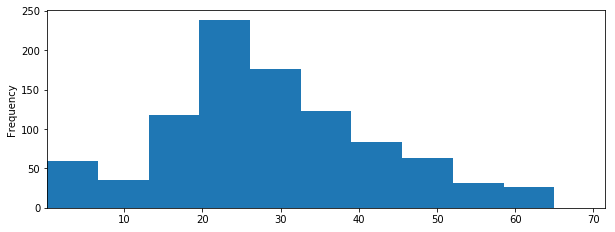

In [203]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.xlim(train_data['age'].min(), train_data['age'].max()*1.1)
train_data['age'].plot('hist')

##### Distribuição dos dados (Fare)

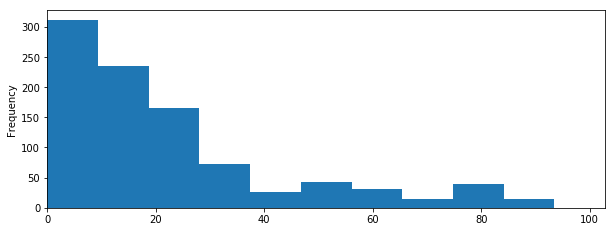

In [204]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plt.xlim(train_data['fare'].min(), train_data['fare'].max()*1.1)
train_data['fare'].plot('hist')

### Correlação dos atributos

Uma vez que o dataset foi analisado e possíveis erros foram corrigidos, é importante também verificar a correlação dos atributos. A correlação é uma métrica estatística que mede a associação entre os atributos. Caso existam atributos altamente correlacionados, pode-se excluir alguns deles, permanecendo apenas um dos atributos correlacionados.

Abaixo temos a tabela de correlação entre os atributos. Foram encontradas duas correlações relevantes. A correlação entre 'Fare' e 'Pclass' (-0.6797) e a correlação entre 'Embarked_C' e 'Embarked_S' (-0.8672). As duas correlações foram ignoradas porque a primeira não foi considerada uma correlação tão relevante, e a última porque são subcategorias de 'Embarked'

In [205]:
train_data.corr()

,pclass,survived,sex,age,sibsp,parch,fare,embarked_C,embarked_Q,embarked_S
pclass,1.000000,-0.282108,-0.091870,-0.416441,0.079060,0.097923,-0.687507,-0.246148,0.135169,0.151080
survived,-0.282108,1.000000,0.512759,-0.066361,-0.018948,0.108442,0.252555,0.203402,-0.056416,-0.154190
sex,-0.091870,0.512759,1.000000,-0.080547,0.100089,0.245174,0.168756,0.074780,0.067743,-0.103662
age,-0.416441,-0.066361,-0.080547,1.000000,-0.261887,-0.180291,0.194622,0.058264,-0.019920,-0.042172
sibsp,0.079060,-0.018948,0.100089,-0.261887,1.000000,0.367706,0.268967,-0.051889,0.009685,0.041834
parch,0.097923,0.108442,0.245174,-0.180291,0.367706,1.000000,0.200215,-0.013035,-0.040143,0.033111
fare,-0.687507,0.252555,0.168756,0.194622,0.268967,0.200215,1.000000,0.249697,-0.082145,-0.182442
embarked_C,-0.246148,0.203402,0.074780,0.058264,-0.051889,-0.013035,0.249697,1.000000,-0.105503,-0.849293
embarked_Q,0.135169,-0.056416,0.067743,-0.019920,0.009685,-0.040143,-0.082145,-0.105503,1.000000,-0.435372
embarked_S,0.151080,-0.154190,-0.103662,-0.042172,0.041834,0.033111,-0.182442,-0.849293,-0.435372,1.000000


### Implementação da Rede Neural

In [206]:
### seed
seed = 3
np.random.seed(seed)

###Dividindo as instâncias (treinamento e teste)
y = train_data['survived'].values
train_data = train_data.drop(['survived'], axis=1)
x = train_data.values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)

In [207]:
### Arquitetura da rede
arch1_model = Sequential()
## camadas
arch1_model.add(Dense(20,input_dim=9, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)))
arch1_model.add(Dropout(0.2))
arch1_model.add(Dense(20, activation='sigmoid'))
arch1_model.add(Dense(25, activation='sigmoid'))
arch1_model.add(Dense(1, activation='sigmoid'))

arch1_model.summary()

## problema de classificação multi-classe
### optimizer='adam'
### optimizer=keras.optimizers.SGD(lr=0.03, momentum=0.80, decay=0.0, nesterov=True)
arch1_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = arch1_model.fit(x_train, y_train, epochs=1000, verbose=0, batch_size=128, validation_data=(x_test, y_test))

#scores = arch1_model.evaluate(x_test, keras.utils.to_categorical(y_test))
print("Training %s: %.2f%%" % (arch1_model.metrics_names[1], scores[1]*100))
print("Training loss: %.4f" % (scores[0]))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_109 (Dense)            (None, 20)                200       
_________________________________________________________________
dropout_8 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_110 (Dense)            (None, 20)                420       
_________________________________________________________________
dense_111 (Dense)            (None, 25)                525       
_________________________________________________________________
dense_112 (Dense)            (None, 1)                 26        
Total params: 1,171
Trainable params: 1,171
Non-trainable params: 0
_________________________________________________________________
Training acc: 81.21%
Training loss: 0.4972


### Gráficos e Matriz de Confusão

Text(0.5,0,'época')

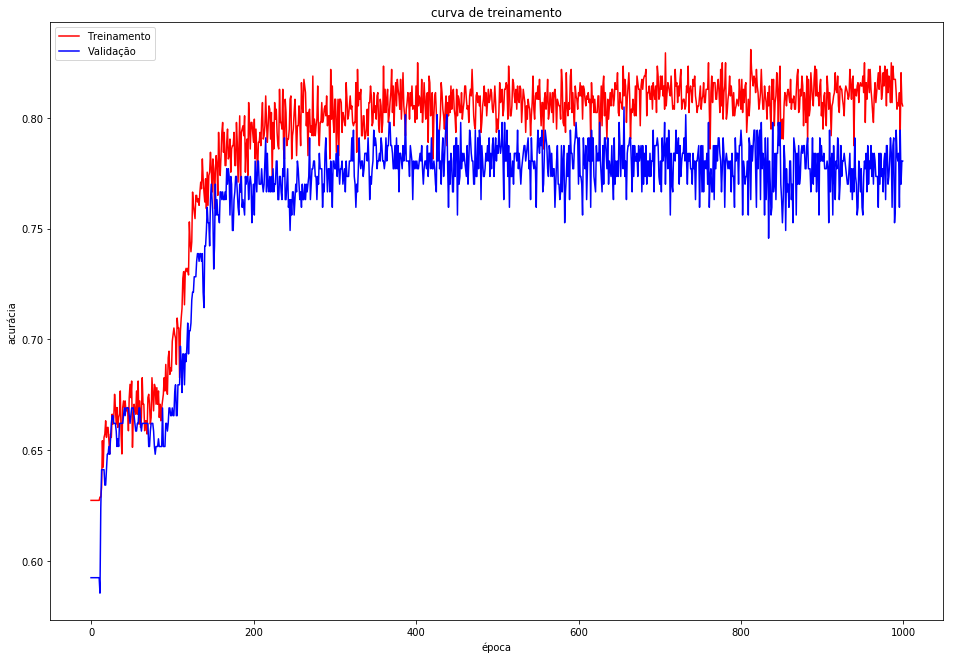

In [208]:
plt.figure(figsize=(16,11))
plt.plot(history.history['acc'], color='red')
plt.plot(history.history['val_acc'], color='blue')
plt.title('curva de treinamento')
plt.ylabel('acurácia')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('época')

Text(0.5,0,'época')

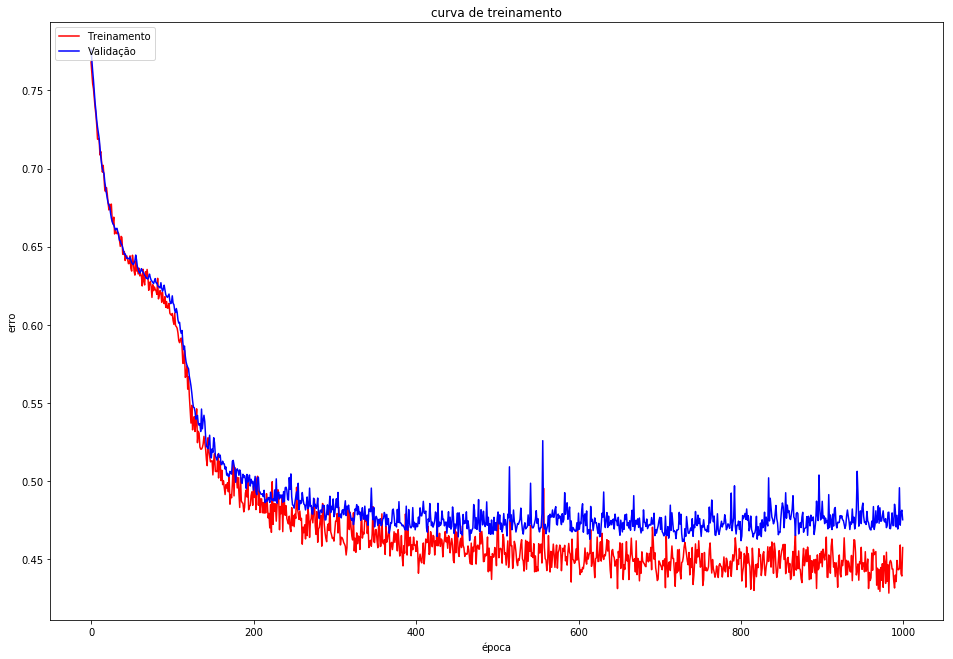

In [209]:
plt.figure(figsize=(16,11))
plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='blue')
plt.title('curva de treinamento')
plt.ylabel('erro')
plt.legend(['Treinamento', 'Validação'], loc='upper left')
plt.xlabel('época')

In [210]:
acc_score = accuracy_score(y_train, np.round(arch1_model.predict(x_train)))
matrix = confusion_matrix(y_train, np.round(arch1_model.predict(x_train)))
print('Acurácia (treinamento): %.2f' % acc_score)
print('Matriz de Confusão (treinamento): \n', matrix)
print('\n\n')
acc_score2 = accuracy_score(y_test, np.round(arch1_model.predict(x_test)))
matrix2 = confusion_matrix(y_test, np.round(arch1_model.predict(x_test)))
print('Acurácia (teste): %.2f' % acc_score2)
print('Matriz de Confusão (teste): \n', matrix2)

Acurácia (treinamento): 0.82
Matriz de Confusão (treinamento): 
 [[396  23]
 [ 96 153]]



Acurácia (teste): 0.78
Matriz de Confusão (teste): 
 [[154  16]
 [ 47  70]]
